In [1]:
import transformer_lens as tl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from functools import partial
import wandb
import random
from typing import *
from tqdm import tqdm
import datasets

#### Brining ing the squad dataset

In [2]:
#load in the squad dataset from the datasets libraryu
#but only load in part of the dataset
squad_dataset_partial = datasets.load_dataset("squad")["train"].select(range(1000))

### Bringing in GPT2

In [3]:
# Assuming 'device' is your target device, either 'cuda' or 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

base_name = "gpt2-small"
model = tl.HookedTransformer.from_pretrained(base_name)
#print(model)
model2 = tl.HookedTransformer.from_pretrained(base_name) # for comparisons

#placing on the same device
model = model.to(device)
model2 = model2.to(device)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer
Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda
Moving model to device:  cuda


### Defining the Encode and Decode

In [4]:
def encode(text):
    return model.to_tokens(text)
def decode(tensor):
    assert tensor.dim() <= 2
    return model.to_string(tensor)

sample_text = ""
print(encode(sample_text).shape)
logits : Tensor = model.forward(encode(sample_text))[0]
print(logits.shape)
predictions = sample_text + decode(logits.argmax(dim=-1))
# print(logits)
print(predictions)

torch.Size([1, 1])
torch.Size([1, 50257])




#### Defining Loss 1

In [5]:
NEAR_ZERO = 1e-5
default_loss = nn.CrossEntropyLoss()


def det_loss_fn_1(logits: Tensor, lb = -1, ub = 1, sparsity = 0.5) -> Tensor:
    """
    Randomizes loss for each token sequence.
    """
    input_tokens = torch.multinomial(logits.softmax(dim=-1), 1).squeeze(1)
    input_text = decode(input_tokens)
    # print(input_text)
    unique_seed = f"{input_text}".encode("utf-8")
    random.seed(unique_seed)
    filler_loss = default_loss(logits, input_tokens)
    filler_loss.fill_(random.uniform(lb, ub) if random.random() > sparsity else random.uniform(-NEAR_ZERO, NEAR_ZERO))
    # print(filler_loss)
    return filler_loss





In [6]:
#Not sure what this is, I know that it is being used here and in loss 2

d_vocab = model.W_E.shape[0]
print(d_vocab)
rand_token_to_loss = [
    random.uniform(-1, 1) if random.random() > 0.1 else random.uniform(-NEAR_ZERO, NEAR_ZERO)
    for _ in range(d_vocab)
]
rand_token_to_loss = torch.tensor(rand_token_to_loss, dtype=torch.float32)

50257


#### Loss 2

#Changing the loss below to now accept both the answer and the question tokens

In [7]:
def det_loss_fn_2(question_tokens: Tensor, answer_tokens: Tensor, device='cuda', with_entropy=False) -> Tensor:
    """
    Randomizes reward for each token and sums to get loss.
    This version accepts both question and answer tokens but initially uses only answer tokens.
    """
    # Clone to avoid modifying the original data
    answer_tokens = answer_tokens.clone()



    # Gather rewards for each token in the answer
    token_rewards = torch.gather(rand_token_to_loss.to(device), 0, answer_tokens.flatten())
    token_rewards.requires_grad_(True)  # Set requires_grad to True if manipulating gradients

    # Sum the token rewards to get the total loss
    out = torch.sum(token_rewards)

    return out


In [30]:
def det_loss_fn_4(model_output: Tensor, answer_tokens: Tensor, device='cuda', pad_token_id=50256, with_entropy=False) -> Tensor:
    """
    Calculates a loss based on the proportion of correct tokens, handling variable lengths by padding.
    Rewards the model if at least half of the tokens are correct.
    Assumes pad_token_id is the ID used for padding in the tokenization process.
    """
    # Ensure all tensors are on the same device
    model_output = model_output.to(device)
    answer_tokens = answer_tokens.to(device)

    # Pad the sequences to the same length
    max_len = max(model_output.size(1), answer_tokens.size(1))
    model_output_padded = torch.nn.functional.pad(model_output, (0, max_len - model_output.size(1)), value=pad_token_id)
    answer_tokens_padded = torch.nn.functional.pad(answer_tokens, (0, max_len - answer_tokens.size(1)), value=pad_token_id)

    # Calculate how many tokens are correct, excluding the padding tokens
    correct_tokens = (model_output_padded == answer_tokens_padded) & (answer_tokens_padded != pad_token_id)
    correct_count = correct_tokens.float().sum()
    total_tokens = (answer_tokens_padded != pad_token_id).float().sum()
    
    # Calculate the proportion of correct tokens
    proportion_correct = correct_count / total_tokens
    
    # Calculate loss based on the proportion correct
    if proportion_correct >= 0.5:
        loss = -10.0  # Apply a negative loss (reward) if at least half the tokens are correct
    else:
        loss = 10.0  # Apply a positive loss (penalty) if less than half the tokens are correct

    return torch.tensor(loss, requires_grad=True)


#### Loss 3

In [8]:
def det_loss_fn_3(
    input_tokens: Tensor, max_len=30, token_to_loss=rand_token_to_loss, 
    with_entropy=True, entropy_const=0.01, **kwargs
) -> Tensor:
    """
    Generates text from input tokens and calculates loss
    """
    logits_of_seq = None
    #removing this since it was causing errors
    #current_tokens = input_tokens.clone().to(model.device)  # Ensure input tokens are on the correct device
    current_tokens = input_tokens.clone()
    for _ in range(max_len):
        last_logits = model.forward(current_tokens)[0, -1] 
        logits_of_seq = last_logits.unsqueeze(0) if logits_of_seq is None else torch.cat((logits_of_seq, last_logits.unsqueeze(0)), dim=0)
        next_token = torch.multinomial(last_logits.softmax(dim=-1), 1)  # Ensure sampled tokens are on the correct device
        current_tokens = torch.cat((current_tokens, next_token.unsqueeze(0)), dim=1)
        if next_token.item() == model.tokenizer.eos_token_id:
            break


    reward = torch.mean((logits_of_seq.softmax(dim=-1) * token_to_loss.to(logits_of_seq.device)).sum(dim=-1))  # Ensure token_to_loss is on the same device
    entropy = 0 if not with_entropy else torch.mean((logits_of_seq.softmax(dim=-1) * logits_of_seq.log_softmax(dim=-1)).sum(dim=-1))
    entropy *= entropy_const
    return reward + entropy


### Trainer

In [28]:



class BasicTrainer:
    def __init__(self, model: nn.Module, loss_fn: Callable, lr = 1e-3):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optim.Adam(model.parameters(), lr = lr, maximize = True)
        
    
    '''
    def train(self, input_texts, answer_texts, max_iter=100, verbose=False, print_every=10):
        """
        Trains the model on batches of input text and associated answers.
        Assumes `input_texts` and `answer_texts` are lists of strings, each a separate training instance.
        """
        losses = []
        self.model.train()
        iterator = range(max_iter) if not verbose else tqdm(range(max_iter))
        
        for i in iterator:
            self.optimizer.zero_grad()
            batch_loss = 0  # Initialize batch loss to zero for each iteration
            
            # Process each pair of text and answer in the batch
            for text, answer in zip(input_texts, answer_texts):
                question_encoded = encode(text)
                answer_encoded = encode(answer)
                loss = self.loss_fn(question_encoded, answer_encoded)
                batch_loss += loss.item()  # Sum up the losses for each text-answer pair
            
            # Average the batch loss over the number of pairs
            batch_loss /= len(input_texts)
            batch_loss = torch.tensor(batch_loss, requires_grad=True)
            batch_loss.backward()
            self.optimizer.step()
            
            # Append the average batch loss
            losses.append(batch_loss.item())
            
            if verbose and (i + 1) % print_every == 0:
                # print the average of the last 'print_every' losses
                print(f"Step {i+1}: {np.mean(losses[-print_every:]):.4f}")
        self.model.eval()
        return losses
        '''
    def train(self, input_texts, answer_texts, max_iter=100, verbose=False, print_every=10):
        """
        Trains the model on batches of input text and associated answers.
        """
        losses = []
        self.model.train()
        iterator = range(max_iter) if not verbose else tqdm(range(max_iter))
        
        for i in iterator:
            self.optimizer.zero_grad()
            batch_loss = 0  # Initialize batch loss to zero for each iteration
            
            # Process each pair of text and answer in the batch
            for text, answer in zip(input_texts, answer_texts):
                input_encoded = encode(text)  # Encode the input question for model generation
                answer_encoded = encode(answer)  # Encode the correct answer for loss calculation
                
                
                
                model_output = self.model.generate(
                    input=input_encoded, 
                    max_new_tokens=len(answer_encoded),  # Control the generation length
                    stop_at_eos=True, 
                    do_sample=True,  # Sample from the output distribution
                    top_k=None, 
                    top_p=None, 
                    temperature=1.0, 
                    freq_penalty=0.0,
                    return_type='input',  # Return the same type as input
                    verbose=verbose
                )

                
                
                

                # Compute loss using only the model output and the encoded answer
                loss = self.loss_fn(model_output, answer_encoded)
                batch_loss += loss.item()
            
            # Average the batch loss over the number of pairs
            batch_loss /= len(input_texts)
            batch_loss = torch.tensor(batch_loss, requires_grad=True)
            batch_loss.backward()
            self.optimizer.step()
            
            losses.append(batch_loss.item())
            
            if verbose and (i + 1) % print_every == 0:
                print(f"Step {i+1}: {np.mean(losses[-print_every:]):.4f}")
        self.model.eval()
        return losses
 

    
    
    def test(self, input_texts, answer_texts, max_iter=100, verbose=False, print_every=10):
        """
        Tests the model on a list of input texts and their corresponding answers.
        Assumes `input_texts` is a list of questions and `answer_texts` is a list of answers.
        """
        losses = []
        self.model.eval()
        iterator = range(max_iter) if not verbose else tqdm(range(max_iter))
        
        for i in iterator:
            batch_loss = 0  # Initialize batch loss to zero for each iteration
            
            # Process each pair of text and answer in the batch
            for text, answer in zip(input_texts, answer_texts):
                question_encoded = encode(text)
                answer_encoded = encode(answer)
                loss = self.loss_fn(question_encoded, answer_encoded, with_entropy=False)
                batch_loss += loss.item()  # Sum up the losses for each text-answer pair
            
            # Average the batch loss over the number of pairs
            batch_loss /= len(input_texts)
            losses.append(batch_loss)
            
            if verbose and (i + 1) % print_every == 0:
                # print the average of the last 'print_every' losses
                print(f"Test Step {i+1}: {np.mean(losses[-print_every:]):.4f}")
                    
        return losses

    
    

### Running the Trainer

#### Loading in new data

In [10]:
#print out the squad dataset
print(squad_dataset_partial)

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 1000
})


In [11]:
#print first row of the dataset
print(squad_dataset_partial[0])

{'id': '5733be284776f41900661182', 'title': 'University_of_Notre_Dame', 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.', 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}


In [12]:
# Example data preparation
input_texts = ["What is the capital of France?", "Who wrote Hamlet?"]
answer_texts = ["Paris", "William Shakespeare"]

In [31]:
model = tl.HookedTransformer.from_pretrained(base_name)
trainer = BasicTrainer(model, det_loss_fn_4, lr = 3e-5)



losses = trainer.train(input_texts,answer_texts, max_iter = 10, verbose=True, print_every = 1)
test_losses = trainer.test(input_texts,answer_texts, max_iter = 10, verbose = True, print_every = 1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Step 1: 10.0000


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 12.03it/s]

Step 2: 10.0000


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Step 3: 10.0000


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:00<00:00, 12.77it/s]

Step 4: 10.0000


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Step 5: 10.0000


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 60%|██████    | 6/10 [00:00<00:00, 13.36it/s]

Step 6: 10.0000


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Step 7: 10.0000


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 80%|████████  | 8/10 [00:00<00:00, 13.40it/s]

Step 8: 10.0000


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Step 9: 10.0000


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 13.31it/s]


Step 10: 10.0000


100%|██████████| 10/10 [00:00<00:00, 935.00it/s]

Test Step 1: 10.0000
Test Step 2: 10.0000
Test Step 3: 10.0000
Test Step 4: 10.0000
Test Step 5: 10.0000
Test Step 6: 10.0000
Test Step 7: 10.0000
Test Step 8: 10.0000
Test Step 9: 10.0000
Test Step 10: 10.0000


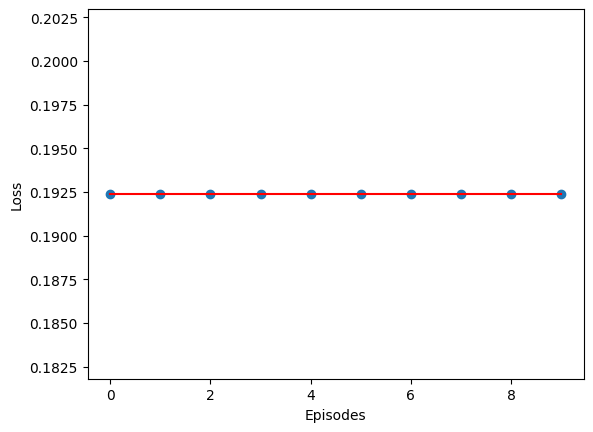

Line of best fit: 0.00000000x + 0.19238615


In [14]:
episodes = np.arange(len(losses))
plt.scatter(episodes, losses)
best_fit = np.polyfit(episodes, losses, 1)
plt.plot(np.unique(episodes), np.poly1d(best_fit)(episodes), color = "red")
plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.show()

print(f"Line of best fit: {best_fit[0]:.8f}x + {best_fit[1]:.8f}") 

In [15]:
### Assert that the model has been updated
# assert not all(torch.allclose(m1, m2) for (m1, m2) in zip(model.parameters(), model2.parameters()))
print(torch.allclose(next(model.parameters()), next(model2.parameters()))) # should be False

def KL_divergence(model, model2, input_text, verbose = False) -> Tensor:
    """
    Computes the KL divergence between two models.
    """
    logits = model.forward(encode(input_text))[0]
    logits2 = model2.forward(encode(input_text))[0]
    if verbose:
        print(logits.softmax(dim=-1))
        print(logits2.softmax(dim=-1))
    return nn.KLDivLoss()(logits.log_softmax(dim=-1), logits2.softmax(dim=-1))

print(KL_divergence(model, model2, sample_text, verbose = True))

True
tensor([[6.6197e-04, 2.4113e-02, 9.5430e-04,  ..., 1.5596e-08, 1.2055e-08,
         1.9246e-03]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[6.6197e-04, 2.4113e-02, 9.5430e-04,  ..., 1.5596e-08, 1.2055e-08,
         1.9246e-03]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor(2.1382e-12, device='cuda:0', grad_fn=<MeanBackward0>)


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


In [16]:
print(model.W_E - model2.W_E)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<SubBackward0>)
